# Introduction

Hello Kagglers, I hope you are doing well. As we all know that there is an ongoing [Google Open Source Expert Prize](https://www.kaggle.com/google-oss-expert-prize?s=09) challenge live on Kaggle. Hence, I thought to contribute to the same. I am starting a whole new series of tutorials where we will learn about the existing methods of building models in JAX. In this tutorial, we are going to build an image classifier purely in JAX. Here is the list of things that we will cover in this notebook:

1. Use the Cifar-10 dataset for training the classifier
2. Build a classifier purely in JAX using no library other than JAX
3. Data augmentation purely in JAX
4. Create a custom training/testing loop in the most simplified manner
5. Discuss the pros and cons of this approach

If you don't know the fundamentals of TensorFlow/JAX, you can use these [notebooks](https://www.kaggle.com/general/296640) to get a solid understanding of both the frameworks. Without any further due, let's start!

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

import jax
import jax.numpy as jnp
from jax import random
from jax import make_jaxpr
from jax.config import config
from jax import value_and_grad
from jax import grad, vmap, pmap, jit
from jax.example_libraries import stax
from jax.example_libraries.stax import (
    Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, BatchNorm
)
from jax.example_libraries import optimizers

np.random.seed(1234)
%config IPCompleter.use_jedi = False

# Dataset

We will use the Cifar-10 dataset for this experiment. You can download it or add it from Kaggle as well, but I am directly importing it from the available `tf.keras.datasets` for the sake of simplicity and brevity

In [2]:
# The downloaded dataset consists of two tuples. The first
# tuple represents the training data consisting of pairs of images
# and labels. Similary, the second tuple consists of validation/test data.
# I will use the second tuple as the validation data for this demo

(x_train, y_train), (x_valid, y_valid) = cifar10.load_data()
print(f"\nNumber of training samples: {len(x_train)} with samples shape: {x_train.shape[1:]}")
print(f"Number of validation samples: {len(x_valid)} with samples shape: {x_valid.shape[1:]}")


# There are 10 classes in this dataset. We will create a dictionary for
# mapping the names of the classes represented by the integer labels
# Labels dictionary
labels_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

170508288/170498071 [==============================] - 4s 0us/step

Number of training samples: 50000 with samples shape: (32, 32, 3)
Number of validation samples: 10000 with samples shape: (32, 32, 3)


# Plotting Utility

Whenever we deal with image data, a few steps related to data processing are always the same. The two most common of them are:
1. Check the raw image data and the corresponding labels to ensure that the labels are correct
2. Plot the augmented samples to ensure that the image augmentation pipeline is correct

Both the steps require the plotting of the samples. Hence, we will define a plotting utility to reuse for these steps.

In [3]:
def plot_samples(x, y, figsize=(12, 8), num_rows=5, num_columns=3, title=None):
    """Plots images with labels as desrciptons.
    
    Args:
        x: Batch of images represented as ndarray
        y: Batch of correspondning labels
        figsize: Plot size
        num_rows: Number of rows in the plot
        num_columns: Number of columns in the plot
        title: Title of the plot (if any). Defaults to `None`
    """
    
    if len(x) != len(y):
        raise ValueError("Number of images and number of labels don't match!")
    
    _, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    
    for i in range(num_rows * num_columns):
        try:
            img = x[i]
            label = str(y[i])
            ax[i // num_columns, i % num_columns].imshow(img)
            ax[i // num_columns, i % num_columns].set_title(label)
            ax[i // num_columns, i % num_columns].axis("off")
        except:
            pass
    
    if title:
        plt.suptitle(str(title))
    plt.show()

# Sanity Check

Now that we have our plotting utility, the first sanity check we will do is check the image data and the corresponding labels. To do so, we will perform the following steps:

1. We will randomly choose `n` numbers in the range `[0, len(training data) - 1]`
2. Based on the chosen indices, we will extract the images and the corresponding samples from the training data
3. Plot the randomly selected samples using our plotting utility for the sanity check

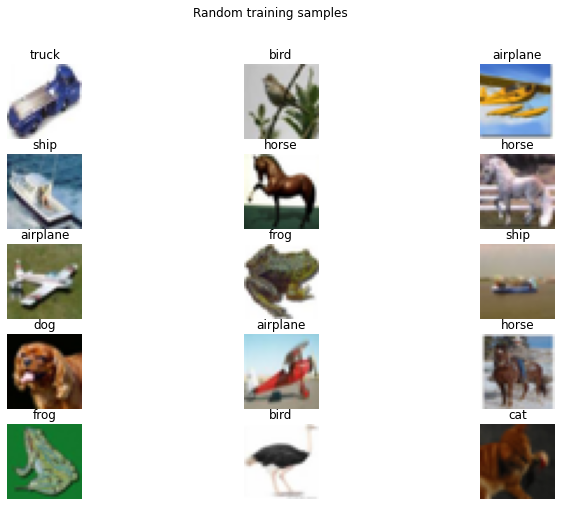

In [4]:
# Select random indices in the range [0, len(training_data) - 1]
sample_size = 15
indices = np.arange(len(x_train))
random_idx = np.random.choice(indices, size=(sample_size,))

# Get the data corresponding to the selected indices
randomly_selected_images = x_train[random_idx]
randomly_selected_labels = y_train[random_idx]

# We will map the integer labels to the class names using our labels dict
randomly_selected_labels = [labels_dict[i[0]] for i in randomly_selected_labels]

# Plot randomly selected samples to check the data
plot_samples(
    x=randomly_selected_images,
    y=randomly_selected_labels,
    title="Random training samples"
)

# Data Augmentation

We will apply image augmentation, and that too, purely in JAX. For augmentation, we will be using three different augmentation techniques:
1. Random rotation by 90 degrees
2. Random horizontal flips
3. Random vertical flips

For each of these augmentations:
1. We will define a function that will either return an augmented image or an identity image
2. Use [**vmap**](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-8-vmap-pmap#Data-Augmentation---Building-a-simple,-fast,-and-scalable-pipeline) to do augmentation in batches
3. [**jit**](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-7-jit-in-jax) the whole augmentation pipeline

In [5]:
def rotate_90(img):
    """Rotates an image by 90 degress k times."""
    return jnp.rot90(img, k=1, axes=(0, 1))


def identity(img):
    """Returns an image as it is."""
    return img


def flip_left_right(img):
    """Flips an image left/right direction."""
    return jnp.fliplr(img)


def flip_up_down(img):
    """Flips an image in up/down direction."""
    return jnp.flipud(img)


def random_rotate(img, rotate):
    """Randomly rotate an image by 90 degrees.
    
    Args:
        img: Array representing the image
        rotate: Boolean for rotating or not
    Returns:
        Rotated or an identity image
    """

    return jax.lax.cond(rotate, rotate_90, identity, img)


def random_horizontal_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_left_right, identity, img)
    
    
def random_vertical_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_up_down, identity, img)





# All the above function are written to work on a single example. 
# We will use `vmap` to get a version of these functions that can
# operate on a batch of images. We will also add the `jit` transformation
# on top of it so that the whole pipeline can be compiled and executed faster
random_rotate_jitted = jit(vmap(random_rotate, in_axes=(0, 0)))
random_horizontal_flip_jitted = jit(vmap(random_horizontal_flip, in_axes=(0, 0)))
random_vertical_flip_jitted = jit(vmap(random_vertical_flip, in_axes=(0, 0)))


def augment_images(images, key):
    """Augment a batch of input images.
    
    Args:
        images: Batch of input images as a jax array
        key: Seed/Key for random functions for generating booleans
    Returns:
        Augmented images with the same shape as the input images
    """
    
    batch_size = len(images)
    
    # 1. Rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_rotate_jitted(images, rotate)
    
    # 2. Flip horizontally
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_horizontal_flip_jitted(augmented, flip)
    
    # 3. Flip vertically
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_vertical_flip_jitted(augmented, flip)
    
    return augmented

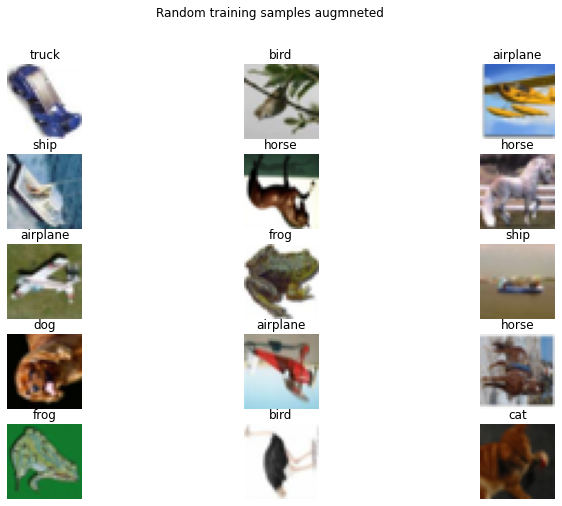

In [6]:
# Let's plot the augmented version of our randomly selected samples.
# This will help us ensure that our augmentation pipeline is working
# as expected.

# Augment the images we selected randomly
randomly_selected_images_augmented = augment_images(
    randomly_selected_images, key=random.PRNGKey(0)
)

# Plot the augmeneted samples
plot_samples(
    x=randomly_selected_images_augmented,
    y=randomly_selected_labels,
    title="Random training samples augmneted"
)

Perfect! The augmentation pipeline is working as expected. Let's move to the next step.

# Data Preprocessing

For data preprocessing, we will apply these two things:
1. We will normalize the image data so that the pixel values for each image is in the range `[0, 1]`
2. We will one-hot encode our labels

In [7]:
# Normalize the image pixels in the range [0, 1]
x_train_normalized = jnp.array(x_train / 255.)
x_valid_normalized = jnp.array(x_valid / 255.)

# One hot encoding applied to the labels. We have 10
# classes in the dataset, hence the depth of OHE would be 10
y_train_ohe = jnp.squeeze(jax.nn.one_hot(y_train, num_classes=10))
y_valid_ohe = jnp.squeeze(jax.nn.one_hot(y_valid, num_classes=10))

print(f"Training images shape:   {x_train_normalized.shape}  Labels shape: {y_train_ohe.shape}")
print(f"Validation images shape: {x_valid_normalized.shape}  Labels shape: {y_valid_ohe.shape}")

Training images shape:   (50000, 32, 32, 3)  Labels shape: (50000, 10)
Validation images shape: (10000, 32, 32, 3)  Labels shape: (10000, 10)


# Data Generator

Now that we have preprocessed our dataset, we need to define our data generator that will stream batches of data, where each batch is a pair of images and the corresponding labels. We will apply data augmentation to the training data only.

In [8]:
def data_generator(images, labels, batch_size=128, is_valid=False, key=None):
    """Generates batches of data from a given dataset.
    
    Args:
        images: Image data represented by a ndarray
        labels: One-hot enocded labels
        batch_size: Number of data points in a single batch
        is_valid: (Boolean) If validation data, then don't shuffle and
                    don't apply any augmentation
        key: PRNG key needed for augmentation
    Yields:
        Batches of images-labels pairs
    """
    
    # 1. Calculate the total number of batches
    num_batches = int(np.ceil(len(images) / batch_size))
    
    # 2. Get the indices and shuffle them
    indices = np.arange(len(images))
    
    if not is_valid:
        if key is None:
             raise ValueError("A PRNG key is required if `aug` is set to True")
        else:
            np.random.shuffle(indices)
    
    for batch in range(num_batches):
        curr_idx = indices[batch * batch_size: (batch+1) * batch_size]
        batch_images = images[curr_idx]
        batch_labels = labels[curr_idx]
        
        if not is_valid: 
            batch_images = augment_images(batch_images, key=key)
        yield batch_images, batch_labels
        
        

# Sanity Check: To make sure that the batches generated by the data
# generator are of correct size, we will just pull a batch of data and
# will check the shape of the images and the labels

sample_data_gen = data_generator(
    images=x_train_normalized,
    labels=y_train_ohe,
    batch_size=8,
    is_valid=False,
    key=random.PRNGKey(0)
)

sample_batch_images, sample_batch_labels = next(sample_data_gen)
print("Batch of images is of shape: ", sample_batch_images.shape)
print("Batch of labels is of shape: ", sample_batch_labels.shape)

# Clean up unnecessary objects
del sample_data_gen, sample_batch_images, sample_batch_labels

Batch of images is of shape:  (8, 32, 32, 3)
Batch of labels is of shape:  (8, 10)


# Model

Now that we have a data streamer that yields batches of preprocessed data, the next step is to define our model (neural network in this case). For this notebook, we are going to use only JAX and no other library. We will be using the `experimental` **Stax** module that offers some commonly used NN functionalities. For documentation on stax, please check out this [page](https://github.com/google/jax/blob/main/jax/example_libraries/stax.py)

**Note:** Any experimental module is supposed to be changed shortly in some ways. Hence, it is not recommended to use it for any big project as the future versions may include some breaking changes.


Using `stax`, we can stack layers to define our model. Each layer constructor function returns an `(init_fun, apply_fun)` functions pair, where
1. **init_fun**: Takes an rng key and an input shape and returns an `(output_shape, params)` pair
2. **apply_fun**: Takes params, inputs, and an rng key and applies the layer (forward pass)

When we stack layers using `stax.serial(...)`, the whole stacked module is just another layer that returns another `(init_fun, apply_fun)` pair. Let's see it in action.

In [9]:
# Use stax to set up the model
net_init, net_apply = stax.serial(
    Conv(32, (3, 3), padding='SAME'),
    Relu,
    Conv(64, (3, 3), padding='SAME'),
    Relu,
    Conv(128, (3, 3), padding='SAME'),
    Relu,
    Conv(256, (3, 3), padding='SAME'),
    Relu,
    MaxPool((2, 2)),
    Flatten,
    Dense(128),
    Relu,
    Dense(10),
    LogSoftmax,
)


# We have defined our model. We need to initialze the params based on the input shape.
# The images in our dataset are of shape (32, 32, 3). Hence we will initialize the 
# network with the input shape (-1, 32, 32, 3). -1 represents the batch dimension here
net_out_shape, net_params = net_init(random.PRNGKey(111), input_shape=(-1, 32, 32, 3))

We have defined the model but we need a few more things before we start traninig:
1. We need to define a loss function (cross-entropy in our case)
2. We need to deine a metric to monitor the performance (accuracy in this case)
3. We need to define the `train` and `test` steps

In [10]:
def loss_fn(params, batch_data):
    """Implements cross-entropy loss function.
    
    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Loss calculated for the current batch
    """
    inputs, targets = batch_data
    preds = net_apply(params, inputs)
    return -jnp.mean(jnp.sum(preds * targets, axis=1))


def calculate_accuracy(params, batch_data):
    """Implements accuracy metric.
    
    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Accuracy for the current batch
    """
    inputs, targets = batch_data
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(net_apply(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)


# We will jit the train and test steps to make them more efficient
@jit
def train_step(step, opt_state, batch_data):
    """Implements train step.
    
    Args:
        step: Integer representing the step index
        opt_state: Current state of the optimizer
        batch_data: A batch of data (images and labels)
    Returns:
        Batch loss, batch accuracy, updated optimizer state
    """
    params = get_params(opt_state)
    batch_loss, batch_gradients = value_and_grad(loss_fn)(params, batch_data)
    batch_accuracy = calculate_accuracy(params, batch_data)
    return batch_loss, batch_accuracy, opt_update(step, batch_gradients, opt_state)


@jit
def test_step(opt_state, batch_data):
    """Implements train step.

    Args:
        opt_state: Current state of the optimizer
        batch_data: A batch of data (images and labels)
    Returns:
        Batch loss, batch accuracy
    """
    params = get_params(opt_state)
    batch_loss = loss_fn(params, batch_data)
    batch_accuracy = calculate_accuracy(params, batch_data)
    return batch_loss, batch_accuracy

# Optimizer
We have implemented everything related to the model. All we need is an `optimizer` to optimize the parameters of our model. We will be using the optimizers defined in this module for [this](https://github.com/google/jax/blob/main/jax/example_libraries/optimizers.py) demo. Again, it's experimental and can change shortly.

The optimizers in the [optimizer module](https://github.com/google/jax/blob/main/jax/example_libraries/optimizers.py) are modeled aa a combination of three different funcations:

1. **init_fun**: Initialize the optimizer state
   - Args
       - params: Model parameters
   - Returns <br>
       - Pytree representing the initial optimizer state
 
2. **update_fun**: Updates the optimizer state
    - Args
        - step: Integer representing the step index.
        - grads: Gradients to be used for updating the optimizer state
        - opt_state: A pytree representing the optimizer state to be updated
    - Returns
        - Updated optimizer state as another pytree

3. **get_params**: Extracts the current state of the optimizer as a pytree
    - Args
        - opt_state: A pytree representing the optimizer state to be updated
    - Returns
        Current state of the optimizer
        

In our experiment, we will use the `Adam` optimizer. Let's initialize the same using the parameters of our model

In [11]:
LEARNING_RATE = 1e-4

# Get the optimizer objects
opt_init, opt_update, get_params = optimizers.adam(step_size=LEARNING_RATE)

# Initialize the state of the optimizer using the parameters
opt_state = opt_init(net_params)

# Training

Let's train our model for a few epochs. We will record the loss and accuracy for both the training data and validation data for each epoch

In [12]:
EPOCHS = 30
BATCH_SIZE = 128

# Initial rng key for the data generator
key = random.PRNGKey(0)

# Lists to record loss and accuracy for each epoch
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Training 
for i in range(EPOCHS):
    num_train_batches = len(x_train) // BATCH_SIZE
    num_valid_batches = len(x_valid) // BATCH_SIZE
    
    # Lists to store loss and accuracy for each batch
    train_batch_loss, train_batch_acc = [], []
    valid_batch_loss, valid_batch_acc = [], []
    
    # Key to be passed to the data generator for augmenting
    # training dataset
    key, subkey = random.split(key)
    
    # Initialize data generators
    train_data_gen = data_generator(x_train_normalized,
                                y_train_ohe,
                                batch_size=BATCH_SIZE,
                                is_valid=False,
                                key=key
                               )

    valid_data_gen = data_generator(x_valid_normalized,
                               y_valid_ohe,
                               batch_size=BATCH_SIZE,
                               is_valid=True
                               )
    
    print(f"Epoch: {i+1:<3}", end=" ")
    
    # Training
    for step in range(num_train_batches):
        batch_data = next(train_data_gen)
        loss_value, acc, opt_state = train_step(step, opt_state, batch_data)
        train_batch_loss.append(loss_value)
        train_batch_acc.append(acc)
    
    # Evaluation on validation data
    for step in range(num_valid_batches):
        batch_data = next(valid_data_gen)
        loss_value, acc = test_step(opt_state, batch_data)
        valid_batch_loss.append(loss_value)
        valid_batch_acc.append(acc)
    
    # Loss for the current epoch
    epoch_train_loss = np.mean(train_batch_loss)
    epoch_valid_loss = np.mean(valid_batch_loss)
    
    # Accuracy for the current epoch
    epoch_train_acc = np.mean(train_batch_acc)
    epoch_valid_acc = np.mean(valid_batch_acc)
    
    training_loss.append(epoch_train_loss)
    training_accuracy.append(epoch_train_acc)
    validation_loss.append(epoch_valid_loss)
    validation_accuracy.append(epoch_valid_acc)
    
    print(f"loss: {epoch_train_loss:.3f}   acc: {epoch_train_acc:.3f}  valid_loss: {epoch_valid_loss:.3f}  valid_acc: {epoch_valid_acc:.3f}")

Epoch: 1   loss: 1.834   acc: 0.340  valid_loss: 1.729  valid_acc: 0.378
Epoch: 2   loss: 1.596   acc: 0.432  valid_loss: 1.558  valid_acc: 0.432
Epoch: 3   loss: 1.487   acc: 0.470  valid_loss: 1.505  valid_acc: 0.453
Epoch: 4   loss: 1.424   acc: 0.493  valid_loss: 1.422  valid_acc: 0.490
Epoch: 5   loss: 1.369   acc: 0.513  valid_loss: 1.379  valid_acc: 0.517
Epoch: 6   loss: 1.339   acc: 0.527  valid_loss: 1.328  valid_acc: 0.534
Epoch: 7   loss: 1.303   acc: 0.542  valid_loss: 1.324  valid_acc: 0.530
Epoch: 8   loss: 1.280   acc: 0.550  valid_loss: 1.275  valid_acc: 0.547
Epoch: 9   loss: 1.259   acc: 0.558  valid_loss: 1.277  valid_acc: 0.547
Epoch: 10  loss: 1.242   acc: 0.565  valid_loss: 1.268  valid_acc: 0.545
Epoch: 11  loss: 1.220   acc: 0.574  valid_loss: 1.205  valid_acc: 0.573
Epoch: 12  loss: 1.203   acc: 0.580  valid_loss: 1.241  valid_acc: 0.571
Epoch: 13  loss: 1.189   acc: 0.585  valid_loss: 1.235  valid_acc: 0.571
Epoch: 14  loss: 1.178   acc: 0.588  valid_loss: 1.

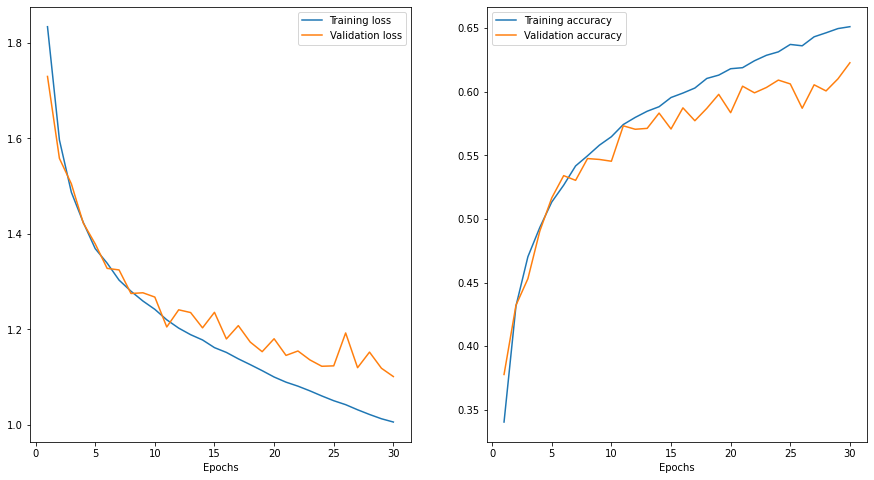

In [13]:
# Let's plot the training and validataion losses as well as
# accuracies for both the dataset. 

_, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].plot(range(1, EPOCHS+1), training_loss)
ax[0].plot(range(1, EPOCHS+1), validation_loss)
ax[0].set_xlabel("Epochs")
ax[0].legend(["Training loss", "Validation loss"])

ax[1].plot(range(1, EPOCHS+1), training_accuracy)
ax[1].plot(range(1, EPOCHS+1), validation_accuracy)
ax[1].set_xlabel("Epochs")
ax[1].legend(["Training accuracy", "Validation accuracy"])

plt.show()

# Evaluation

Let's take a batch of random samples from the validation data. Check how many of them we can predict correctly, and let's plot the images in the selected batch, along with the predicted labels for the same.

Accuracy on randomly selected sample of size 16 is 62.50 %



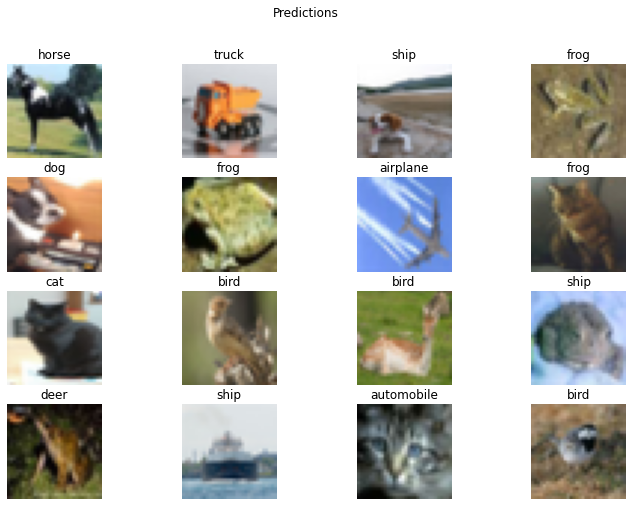

In [14]:
# Select some samples randomly from the validation data
np.random.seed(0)
random_idx = np.random.choice(np.arange(len(x_valid_normalized)), size=16)
random_valid_samples = x_valid_normalized[random_idx], y_valid_ohe[random_idx]

# Get the updated parameters from the optimizer
params = get_params(opt_state)

# Calculate the accuracy for these samples
acc = calculate_accuracy(params, random_valid_samples)
predicted_class = jnp.argmax(net_apply(params, random_valid_samples[0]), axis=1)

# Map the predicted class to the original class names
predicted_class = [labels_dict[pred] for pred in predicted_class]

# Plot the samples along with the predictions
print(f"Accuracy on randomly selected sample of size {len(random_idx)} is {acc*100:.2f} %\n")
plot_samples(x=x_valid[random_idx], y=predicted_class, num_rows=4, num_columns=4, title="Predictions")

# Pros and Cons

Now that we have built a classifier purely in JAX. Let's talk about the pros and cons of this approach.

## Pros
1. Everything in this approach is modeled as a function, including the layers, the models, and the optimizers
2. Because of the above fact, it is very straightforward to code the whole thing in a single module
3. Super flexible and provides full control to the end-user. Easy to define new layers, optimizers, etc

## Cons
1. Building a model in OOP style as done in Keras is cleaner and much better IMO compared to functional all the way
2. Doesn't give you information on the input shape, output shape, and the connections of the layers in a nicely formatted table as provided by Keras. Also, there is no easy way to name the layers used in the model
3. Some layers behave differently at the test stage as compared to the training stage, e.g. BatchNorm. It isn't very clear from the documentation how to enable that behavior. 
4. What if I have to add L2 regularization to the layers? 

To be fair, **Stax** isn't supposed to be a full-fledged high-level API for building models in JAX because of two reasons:
1. It is still *experimental*
2. It is minimal yet very flexible. It can serve as a reference point if you want to develop a new high-level API for JAX


I hope you enjoyed the tutorial! Please let me know in the comments section if you have any questions/feedback.


# References
1. https://jax.readthedocs.io/en/latest/
2. https://www.cs.toronto.edu/~kriz/cifar.html
3. https://keras.io/
4. https://github.com/google/jax/blob/main/jax/example_libraries/stax.py